<center> <img src=https://childrenplus.ru/wp-content/uploads/Vsemirnyy_Den_Nekommercheskikh_Organizatsiy_2021.jpg alt="drawing" style="width:400px;"> 

# <center> Итоговый проект: Государственные деньги у НКО

**Цель проекта** — спрогнозировать вероятность получения грантов от государства/госконтрактов для организации в зависимости от её характеристик.

**Задача проекта** — проверить, есть ли зависимость вероятности получения грантов от государства/госконтрактов:
* от региона регистрации организации;
* от возраста организации;
* от экономической деятельности организации.

Разделим эту задачу на две части:
* В первой части мы ознакомимся с данными и очистим их от пропусков, выбросов и дубликатов.

* Во второй части мы проведем разведывательный анализ данных, займемся построением моделей, сравним их результаты и сделаем финальный вывод.

In [1]:
# импорт библиотек
import json 
import glob 
import pandas as pd 
import numpy as np
from numpy.random import rand
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots 

import scipy
from scipy.stats import shapiro
from scipy.stats import normaltest
import scipy.stats as stats

from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
import category_encoders as ce 
from sklearn import linear_model
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from imblearn.over_sampling import SMOTE
import optuna
import pickle
import joblib

# Базовый анализ и знакомство с данными

In [2]:
# Get data file names
path = r'data'
filenames = glob.glob(path + "/*.json")

dfs = []
for filename in filenames:
    dfs.append(pd.read_json(filename, lines = True))

# Concatenate all data into one DataFrame
main_df = pd.concat(dfs, ignore_index=True)

In [3]:
#main_df.to_csv('data/main_df.csv', index=False)
#main_df = pd.read_csv('data/main_df.csv')

In [4]:
# посмотрим на таблицу
display(main_df.head(3))
display(main_df.tail(3))

,minjustRegNum,regionName,logo,statusDetail,fullName,dateReg,minjustForm,charter,minjustStatus,ogrn,...,hasRegionalSupport,addOkved,okato,okfs,website_punycode,shortName,dateOgrn,predecessors,socialMedia,reports
0,7814061218,Санкт-Петербург,NaN,"{'name': None, 'code': None, 'shortName': 'Дей...",МЕЖРЕГИОНАЛЬНАЯ АНТРОПОСОФСКАЯ МЕДИЦИНСКАЯ АСС...,None,"Объединения (союз, ассоциация) юридических лиц",NaN,Зарегистрирована,1207800141790,...,False,[],"{'name': None, 'code': None}","{'name': None, 'code': None}",None,"""АМА""",{'$date': '2020-10-30T00:00:00.000Z'},[],"{'youtube': None, 'vk': None, 'facebook': None...",[]
1,7714017452,Москва,NaN,"{'name': None, 'code': None, 'shortName': 'Дей...","ФОНД ""СОДЕЙСТВИЕ ДУХОВНОМУ РАЗВИТИЮ ЧЕЛОВЕКА ""...",None,Некоммерческий фонд,NaN,Зарегистрирована,1207700349152,...,False,"[{'name': 'Издание книг', 'code': '58.11', 've...","{'name': None, 'code': None}","{'name': None, 'code': None}",None,"ФОНД ""УНИВЕРСАЛИСТ М""",{'$date': '2020-09-23T00:00:00.000Z'},[],"{'youtube': None, 'vk': None, 'facebook': None...","[{'localUrl': 'http://cdnx.h5.crftr.net/f/4,18..."
2,7814170160,Санкт-Петербург,NaN,"{'name': None, 'code': None, 'shortName': 'Дей...","КОЛЛЕГИЯ АДВОКАТОВ ""САНКТ-ПЕТЕРБУРГСКАЯ КОЛЛЕГ...",None,Коллегия адвокатов,NaN,Зарегистрирована,1207800011430,...,False,[],"{'name': None, 'code': None}","{'name': None, 'code': None}",None,None,{'$date': '2020-02-03T00:00:00.000Z'},[],"{'youtube': None, 'vk': None, 'facebook': None...",[]


,minjustRegNum,regionName,logo,statusDetail,fullName,dateReg,minjustForm,charter,minjustStatus,ogrn,...,hasRegionalSupport,addOkved,okato,okfs,website_punycode,shortName,dateOgrn,predecessors,socialMedia,reports
747031,None,Ханты-Мансийский автономный округ - Югра,NaN,"{'name': None, 'code': None, 'shortName': 'Дей...","СОВЕТ САМОУПРАВЛЕНИЯ МИКРОРАЙОНА ""А""",{'$date': '1998-01-01T00:00:00.000Z'},None,NaN,None,1068602157447,...,False,[],"{'name': None, 'code': None}","{'name': None, 'code': None}",None,"СОВЕТ САМОУПРАВЛЕНИЯ МИКРОРАЙОНА ""А""",{'$date': '2006-10-11T00:00:00.000Z'},[],"{'youtube': None, 'vk': None, 'facebook': None...",[]
747032,None,Кемеровская область,NaN,"{'name': None, 'code': None, 'shortName': 'Дей...",КООПЕРАТИВ РИТУАЛ ПО ОКАЗАНИЮ РИТУАЛЬНЫХ УСЛУГ...,{'$date': '1987-12-05T00:00:00.000Z'},None,NaN,None,1064202020343,...,False,[],"{'name': None, 'code': None}","{'name': None, 'code': None}",None,None,{'$date': '2006-06-05T00:00:00.000Z'},[],"{'youtube': None, 'vk': None, 'facebook': None...",[]
747033,None,Новосибирская область,NaN,"{'name': None, 'code': None, 'shortName': 'Дей...",КООПЕРАТИВ ТРАНСПОРТНИК,{'$date': '1990-10-23T00:00:00.000Z'},None,NaN,None,1065405122408,...,False,[],"{'name': None, 'code': None}","{'name': None, 'code': None}",None,None,{'$date': '2006-07-05T00:00:00.000Z'},[],"{'youtube': None, 'vk': None, 'facebook': None...",[]


In [5]:
# информация о таблице
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 747034 entries, 0 to 747033
Data columns (total 38 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   minjustRegNum       462302 non-null  object 
 1   regionName          747009 non-null  object 
 2   logo                0 non-null       float64
 3   statusDetail        747034 non-null  object 
 4   fullName            747034 non-null  object 
 5   dateReg             321416 non-null  object 
 6   minjustForm         462302 non-null  object 
 7   charter             0 non-null       float64
 8   minjustStatus       462302 non-null  object 
 9   ogrn                747034 non-null  int64  
 10  opf                 747034 non-null  object 
 11  oktmo               747034 non-null  object 
 12  egrulStatus         747034 non-null  object 
 13  mainOkved           747034 non-null  object 
 14  regionCode          747034 non-null  int64  
 15  incomeTotal         747034 non-nul

In [6]:
# выведем названия столбцов, где число пропусков больше 0 
cols_null_percent = main_df.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
display(cols_with_null)

logo                100.000000
charter             100.000000
website              99.292402
website_punycode     99.292402
email                98.907948
dateReg              56.974381
okpo                 53.491140
dateLiquid           46.460134
minjustRegNum        38.114999
minjustForm          38.114999
minjustStatus        38.114999
shortName            19.977806
kpp                   0.490205
inn                   0.348579
regionName            0.003347
dtype: float64

# Предобработка и очистка данных

In [7]:
# удалим признаки, у которых пропусков больше 30% (кроме dateReg и dateLiquid, они еще понадобятся), а также неинформативные признаки
df = main_df.copy()
cols_to_del = ['logo', 'charter', 'website', 'website_punycode', 'email', 'okpo', 'minjustRegNum', 'minjustForm', 'minjustStatus', 'successors', 'predecessors', 'administrators']
#cols_to_del = [0, 2, 6, 7, 8, 16, 18, 20, 22, 25, 32, 35]
#df = df.drop(df.columns[cols_to_del], axis= 1)
df = df.drop(cols_to_del, axis= 1)

In [8]:
# посмотрим на оставшиеся пропуски
df.isnull().sum() 

regionName                25
statusDetail               0
fullName                   0
dateReg               425618
ogrn                       0
opf                        0
oktmo                      0
egrulStatus                0
mainOkved                  0
regionCode                 0
incomeTotal                0
incomeDetail               0
inn                     2604
originDate                 0
dateLiquid            347073
address                    0
okogu                      0
kpp                     3662
hasRegionalSupport         0
addOkved                   0
okato                      0
okfs                       0
shortName             149241
dateOgrn                   0
socialMedia                0
reports                    0
dtype: int64

## Преобразование признака региона

In [9]:
# посмотрим на пустые значения признака regionName
rn = df[['regionCode', 'regionName', 'address']]
rn[rn.regionName.isnull()]

,regionCode,regionName,address
31530,0,None,"420015, РЕСПУБЛИКА Татарстан, УЛИЦА К.МАРКСА, ..."
46886,0,None,"420100, РЕСПУБЛИКА ТАТАРСТАН, УЛИЦА ПРОСПЕКТ П..."
51173,0,None,"420140, РЕСПУБЛИКА ТАТАРСТАН, УЛИЦА КАРАТАУ, Д..."
53316,0,None,"420101, РЕСПУБЛИКА ТАТАРСТАН, УЛИЦА МАВЛЮТОВА,..."
53323,0,None,"РЕСПУБЛИКА ТАТАРСТАН, УЛИЦА Н.ЕРШОВА, ДОМ 28, ..."
53841,0,None,"420021, РЕСПУБЛИКА ТАТАРСТАН, УЛИЦА КАМАЛА ГАЛ..."
54766,0,None,"420044, РЕСПУБЛИКА ТАТАРСТАН, УЛИЦА ЯМАШЕВА, Д..."
61942,0,None,"420133, РЕСПУБЛИКА ТАТАРСТАН, УЛИЦА ЛАВРЕНТЬЕВ..."
62898,0,None,"420015, РЕСПУБЛИКА ТАТАРСТАН, УЛИЦА К.МАРКСА, ..."
68375,0,None,"РЕСПУБЛИКА ТАТАРСТАН, УЛИЦА ПРОСПЕКТ ПОБЕДЫ"


In [10]:
# посмотрим на адреса с нулевым кодом региона
rn[rn.regionCode == 0]

,regionCode,regionName,address
31530,0,None,"420015, РЕСПУБЛИКА Татарстан, УЛИЦА К.МАРКСА, ..."
46886,0,None,"420100, РЕСПУБЛИКА ТАТАРСТАН, УЛИЦА ПРОСПЕКТ П..."
51173,0,None,"420140, РЕСПУБЛИКА ТАТАРСТАН, УЛИЦА КАРАТАУ, Д..."
53316,0,None,"420101, РЕСПУБЛИКА ТАТАРСТАН, УЛИЦА МАВЛЮТОВА,..."
53323,0,None,"РЕСПУБЛИКА ТАТАРСТАН, УЛИЦА Н.ЕРШОВА, ДОМ 28, ..."
53841,0,None,"420021, РЕСПУБЛИКА ТАТАРСТАН, УЛИЦА КАМАЛА ГАЛ..."
54766,0,None,"420044, РЕСПУБЛИКА ТАТАРСТАН, УЛИЦА ЯМАШЕВА, Д..."
61942,0,None,"420133, РЕСПУБЛИКА ТАТАРСТАН, УЛИЦА ЛАВРЕНТЬЕВ..."
62898,0,None,"420015, РЕСПУБЛИКА ТАТАРСТАН, УЛИЦА К.МАРКСА, ..."
68375,0,None,"РЕСПУБЛИКА ТАТАРСТАН, УЛИЦА ПРОСПЕКТ ПОБЕДЫ"


In [11]:
# Все пропуски и нулевые значения кода региона относятся к Республике Татарстан. Код региона Республики Татарстан - 16, заполним пропуски.
#rn[rn.regionCode == 16]
df['regionName'] = df['regionName'].fillna('Республика Татарстан')
df['regionCode'] = df['regionCode'].apply(lambda x: 16 if x==0 else x)
# проверим пропуски
df['regionName'].isnull().sum()

0

In [12]:
# посмотрим на спиок регионов
df.regionName.value_counts()

Москва                          80178
Московская область              37927
Санкт-Петербург                 31767
Краснодарский край              23337
Свердловская область            23030
                                ...  
Республика Ингушетия             1249
Еврейская автономная область     1197
Чукотский автономный округ        505
Ненецкий автономный округ         398
Не определено                      91
Name: regionName, Length: 86, dtype: int64

In [13]:
# выясним адрес признака regionName со значением 'Не определено' 
not_defined = rn[rn.regionName == 'Не определено']
not_defined.value_counts()

regionCode  regionName     address                                                              
99          Не определено  468320, ГОРОД БАЙКОНУР, УЛИЦА ЯНГЕЛЯ                                     11
                           468320, ГОРОД БАЙКОНУР, УЛИЦА ЯНГЕЛЯ, РАЙОН ТЭЦ                           6
                           468320, ГОРОД БАЙКОНУР, МИКРОРАЙОН 6-Й                                    3
                           468320, ГОРОД БАЙКОНУР, УЛИЦА ЯНГЕЛЯ, РАЙОН ТЭЦ, КОРПУС -, КВ./ОФИС -     3
                           468320, ГОРОД БАЙКОНУР, ПРОСПЕКТ АБАЯ, ДОМ 0                              2
                                                                                                    ..
                           468320, ГОРОД БАЙКОНУР, МИКРОРАЙОН 7-Й, ДОМ 21Б, КВ./ОФИС 47              1
                           468320, ГОРОД БАЙКОНУР, МИКРОРАЙОН 7-Й, ДОМ 24, КВ./ОФИС 1                1
                           468320, ГОРОД БАЙКОНУР, МИКРОРАЙОН 7-Й, ЗАПАДНАЯ СТО

In [14]:
# проверим, все ли значения в с региональным кодом-99 принадлежат городу Байконур
def get_not_defined(row):
    if 'БАЙКОНУР' in row:
        return 'Yes'
    return 'No'

not_defined['regionCode_99'] = not_defined['address'].apply(get_not_defined)
not_defined['regionCode_99'].value_counts()

Yes    91
Name: regionCode_99, dtype: int64

In [15]:
# переименуем значение признака regionName = 'Не определено' 
df['regionName'] = df['regionName'].apply(lambda x: 'БАЙКОНУР' if x=='Не определено' else x)

In [16]:
# посмотрим на уникальные значения данных признаков
df[['regionCode', 'regionName']].nunique()

regionCode    92
regionName    86
dtype: int64

Уникальных значений региональных кодов больше, чем наименований регионов, это связано с тем, что некоторые регионы имеют 2-3 кода. В дальнейшем признак regionCode можно будет удалить, а к regionName применить двоичное кодирование.

## Преобразование признаков со статусами

In [17]:
# т.к. в датасете много признаков в виде словаря, создадим функции для извлечения наименования, кода и версии
def get_name(name):
    if name is not None:
        return name['name']
    
def get_code(code):
    if code is not None:
        return code['code']
    
def get_version(ver):
    if ver is not None:
        return ver['version']

In [18]:
df.statusDetail[2]

{'name': None, 'code': None, 'shortName': 'Действующая'}

In [19]:
# создадим новые признаки
df['status_name'] = df['statusDetail'].apply(get_name)
df['status_code'] = df['statusDetail'].apply(get_code)
df['status_shortName'] = df['statusDetail'].apply(lambda x: x['shortName'])

# удалим старый признак
df = df.drop(['statusDetail'], axis= 1)
# посмотрим на значения
print(df.status_shortName.value_counts(), 
      df.status_name.value_counts())

Действующая                730697
Недействующая                8403
Ликвидируется                6489
В состоянии банкротства       783
Реорганизуется                662
Name: status_shortName, dtype: int64 Находится в стадии ликвидации                                                                                                                                                                     6489
Регистрация признана ошибочной по решению регоргана                                                                                                                                               3458
Регистрирующим органом принято решение о предстоящем исключении юридического лица из ЕГРЮЛ (недействующее юридическое лицо)                                                                       3268
Регистрирующим органом принято решение о предстоящем исключении юридического лица из ЕГРЮЛ (наличие в ЕГРЮЛ сведений о юридическом лице, в отношении которых внесена запись о недостоверности)    13

In [20]:
# статус организации на основании данных ЕГРЮЛ
df.egrulStatus.value_counts()

Ликвидирована    406134
Действует        340900
Name: egrulStatus, dtype: int64

In [21]:
# преобразуем данный признак для удобства
df['egrulStatus'] = df['egrulStatus'].apply(lambda x: 1 if x=='Действует' else 0)
df.egrulStatus.value_counts()

0    406134
1    340900
Name: egrulStatus, dtype: int64

In [22]:
# проверим на соответствие признаков со статусами
df[['egrulStatus', 'status_shortName']].value_counts()

egrulStatus  status_shortName       
0            Действующая                399107
1            Действующая                331590
0            Недействующая                7027
1            Ликвидируется                6489
             Недействующая                1376
             В состоянии банкротства       783
             Реорганизуется                662
dtype: int64

In [23]:
# Наблюдается несоответствие данных признаков, status_shortName удалим
df = df.drop(['status_shortName'], axis= 1)

## Преобразование дат

In [24]:
# посмотрим на признаки с датами
df[['originDate', 'dateReg', 'dateOgrn', 'dateLiquid']]

,originDate,dateReg,dateOgrn,dateLiquid
0,{'$date': '2020-10-30T00:00:00.000Z'},None,{'$date': '2020-10-30T00:00:00.000Z'},None
1,{'$date': '2020-09-23T00:00:00.000Z'},None,{'$date': '2020-09-23T00:00:00.000Z'},None
2,{'$date': '2020-02-03T00:00:00.000Z'},None,{'$date': '2020-02-03T00:00:00.000Z'},None
3,{'$date': '2020-09-23T00:00:00.000Z'},None,{'$date': '2020-09-23T00:00:00.000Z'},None
4,{'$date': '2020-07-08T00:00:00.000Z'},None,{'$date': '2020-07-08T00:00:00.000Z'},None
...,...,...,...,...
747029,{'$date': '2006-03-29T00:00:00.000Z'},None,{'$date': '2006-03-29T00:00:00.000Z'},{'$date': '2009-01-12T00:00:00.000Z'}
747030,{'$date': '2006-08-09T00:00:00.000Z'},None,{'$date': '2006-08-09T00:00:00.000Z'},{'$date': '2012-08-15T00:00:00.000Z'}
747031,{'$date': '1998-01-01T00:00:00.000Z'},{'$date': '1998-01-01T00:00:00.000Z'},{'$date': '2006-10-11T00:00:00.000Z'},{'$date': '2006-10-11T00:00:00.000Z'}
747032,{'$date': '1987-12-05T00:00:00.000Z'},{'$date': '1987-12-05T00:00:00.000Z'},{'$date': '2006-06-05T00:00:00.000Z'},{'$date': '2006-06-05T00:00:00.000Z'}


In [25]:
# на первый взгляд признак originDate совпадает с признаками dateReg или dateOgrn, проверим по всему df
df[(df.originDate == df.dateReg) | (df.originDate == df.dateOgrn)].shape[0] == len(df)

True

In [26]:
# следовательно признаки dateReg и dateOgrn можно удалить
df = df.drop(['dateReg', 'dateOgrn'], axis= 1)

In [27]:
# преобразуем дату регистрации организации в формат datetime
df['originDate'] = df['originDate'].apply(lambda x: pd.to_datetime(x['$date']))
df['originDate']

0        2020-10-30 00:00:00+00:00
1        2020-09-23 00:00:00+00:00
2        2020-02-03 00:00:00+00:00
3        2020-09-23 00:00:00+00:00
4        2020-07-08 00:00:00+00:00
                    ...           
747029   2006-03-29 00:00:00+00:00
747030   2006-08-09 00:00:00+00:00
747031   1998-01-01 00:00:00+00:00
747032   1987-12-05 00:00:00+00:00
747033   1990-10-23 00:00:00+00:00
Name: originDate, Length: 747034, dtype: datetime64[ns, UTC]

In [28]:
# преобразуем дату ликвидации организации в формат datetime и заполним пропуски для удобства
df['dateLiquid'] = df['dateLiquid'].apply(lambda x: pd.to_datetime(x['$date']) if x is not None else 0)
df['dateLiquid']

0                                 0
1                                 0
2                                 0
3                                 0
4                                 0
                    ...            
747029    2009-01-12 00:00:00+00:00
747030    2012-08-15 00:00:00+00:00
747031    2006-10-11 00:00:00+00:00
747032    2006-06-05 00:00:00+00:00
747033    2006-07-05 00:00:00+00:00
Name: dateLiquid, Length: 747034, dtype: object

In [29]:
# создадим новый признак возраста организации и для удобства переведем его в годы

# т.к. данные за 2021 год, возьмем точку отсчета - 31.12.2021г.
date_end = pd.to_datetime('2021-12-31', utc=True)
def age_org(dateLiquid, originDate):
    if dateLiquid != 0:
        return (dateLiquid - originDate).days 
    else:
        return (date_end - originDate).days
    
df['age_org'] = df.apply(lambda row: age_org(row['dateLiquid'], row['originDate']), axis=1)
df['age_org'] = round(df['age_org'] / 365,1)

# удаление признаков
df = df.drop(['dateLiquid', 'originDate'], axis= 1)
# описательная статистика
df['age_org'].describe()

count    747034.000000
mean         12.418269
std           8.936231
min          -2.000000
25%           5.500000
50%          10.600000
75%          17.900000
max         138.700000
Name: age_org, dtype: float64

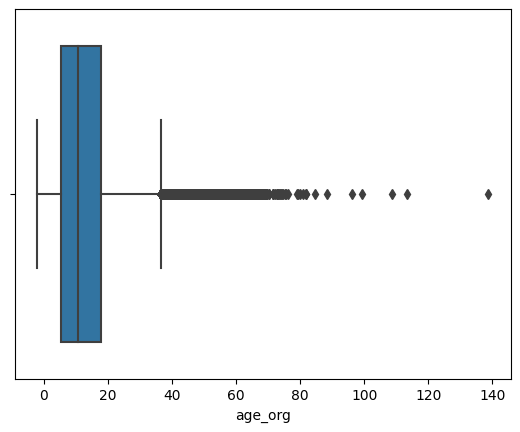

In [30]:
# посмотрим на распределение признака
sns.boxplot(data=df, x='age_org');

In [31]:
# на графике и в статистике можно увидеть, что есть организации с минусовым и нулевым значением возраста, посмотрим на их статус 
df[df.age_org <= 0]['egrulStatus'].value_counts()

0    2538
Name: egrulStatus, dtype: int64

In [32]:
# все они уже недействующие, удалим строки, где возраст организации меньше и равен 0, а также больше 80 (скорей всего это выбросы)
df = df[(df.age_org > 0) & (df.age_org < 80)]
df['age_org'].describe()

count    744485.000000
mean         12.459381
std           8.915977
min           0.100000
25%           5.500000
50%          10.600000
75%          17.900000
max          79.200000
Name: age_org, dtype: float64

## Преобразование признаков классификаторов

In [33]:
# посмотрим признак основной ОКВЭД (Общероссийский классификатор видов экономической деятельности)
df['mainOkved'][1]

{'name': 'Предоставление прочих финансовых услуг, кроме услуг по страхованию и пенсионному обеспечению, не включенных в другие группировки',
 'code': '64.99',
 'version': 'ОК 029-2014 (КДЕС Ред. 2)'}

In [34]:
# создадим новые признаки
df['mainOkved_name'] = df['mainOkved'].apply(get_name)
df['mainOkved_code'] = df['mainOkved'].apply(get_code)
df['mainOkved_ver'] = df['mainOkved'].apply(get_version)
df = df.drop(['mainOkved'], axis= 1)

print("Количество пустых значений: ", df.mainOkved_name.isnull().sum(), df.mainOkved_code.isnull().sum())
print("Количество уникальных значений: ", df.mainOkved_name.nunique(), df.mainOkved_code.nunique())
print("Версии ОКВЭД: ", df.mainOkved_ver.value_counts())

Количество пустых значений:  202179 202179
Количество уникальных значений:  1923 2040
Версии ОКВЭД:  ОК 029-2014 (КДЕС Ред. 2)    424181
ОК 029-2001 (КДЕС Ред. 1)    320304
Name: mainOkved_ver, dtype: int64


Количество уникальных значений наименований ОКВЭД не совпадает с количеством уникальных значений кодов, причиной скорей всего являются разные версии ОКВЭД (2001 и 2014гг). Т.е. к одному наименованию - разные коды ОКВЭД. Т.к. уникальных наименований меньше, чем кодов, последний признак можно будет в дальнейшем удалить, а к наименованию применить двоичное кодирование.

Т.к. одной из подзадач является определение зависимости вероятности получения государственного финансирования от экономической деятельности органиазции, удалим строки с пустым ОКВЭД.

In [35]:
df = df.dropna(subset=['mainOkved_name'])
df.shape

(542306, 26)

In [36]:
# обозначим старую версию ОКВЭД ред.1 - 0, новую версию ред.2 - 1 для удобства
df['mainOkved_ver'] = df['mainOkved_ver'].apply(lambda x: 0 if x == 'ОК 029-2001 (КДЕС Ред. 1)' else 1)
df['mainOkved_ver'].value_counts()

1    424181
0    118125
Name: mainOkved_ver, dtype: int64

In [37]:
# посмотрим на признак дополнительного ОКВЭДа
df['addOkved'][1]

[{'name': 'Издание книг',
  'code': '58.11',
  'version': 'ОК 029-2014 (КДЕС Ред. 2)'},
 {'name': 'Издание газет',
  'code': '58.13',
  'version': 'ОК 029-2014 (КДЕС Ред. 2)'},
 {'name': 'Виды издательской деятельности прочие',
  'code': '58.19',
  'version': 'ОК 029-2014 (КДЕС Ред. 2)'},
 {'name': 'Издание аудиовизуальных произведений на магнитных, электронных и цифровых носителях',
  'code': '59.20.1',
  'version': 'ОК 029-2014 (КДЕС Ред. 2)'}]

In [38]:
# преобразуем данный признак в количество дополнительного ОКВЭДа
df['addOkved'] = df['addOkved'].apply(lambda x: len(x))

# и создадим бинарный признак наличия дополнительного ОКВЭД
df['addOkved_bool'] = df['addOkved'].apply(lambda x: 1 if x > 0 else 0)

# описательная статистика
df[['addOkved', 'addOkved_bool']].describe()

,addOkved,addOkved_bool
count,542306.000000,542306.000000
mean,2.918681,0.502395
std,8.044923,0.499995
min,0.000000,0.000000
25%,0.000000,0.000000
50%,1.000000,1.000000
75%,3.000000,1.000000
max,985.000000,1.000000


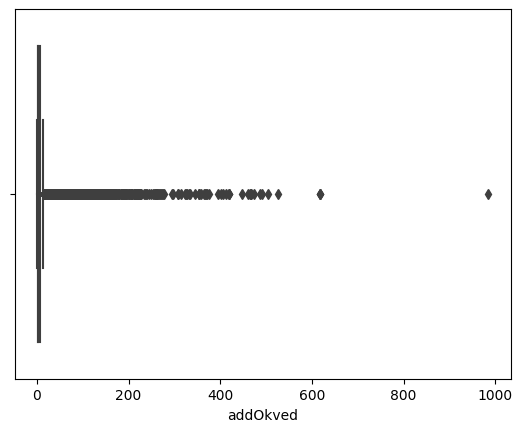

In [39]:
# посмотрим на распределение признака
df_addOkved = df[df['addOkved']>0]
sns.boxplot(data=df_addOkved, x='addOkved');

In [40]:
# максимальные значения данного признака
df['addOkved'].sort_values(ascending=False).head(10)

678030    985
281827    618
292463    618
1585      618
570142    526
263900    505
261407    491
250909    486
252779    473
655441    468
Name: addOkved, dtype: int64

Как показывает график и статистика, есть учреждения у которых количесто дополнительного ОКВЭДа больше 600, возможно так и есть, но лучше уменьшим для наглядности.

In [41]:
df['addOkved'] = df['addOkved'].apply(lambda x: 526 if x > 600 else x)
df['addOkved'].describe()

count    542306.000000
mean          2.917325
std           7.928907
min           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
max         526.000000
Name: addOkved, dtype: float64

In [42]:
# посмотрим признак ОКОПФ (Общероссийский классификатор организационно-правовых форм)
df.opf[1]

{'name': 'Фонды', 'code': '70400', 'version': 'okopf'}

In [43]:
# создадим новые признаки
df['opf_name'] = df['opf'].apply(get_name)
df['opf_code'] = df['opf'].apply(get_code)
df['opf_ver'] = df['opf'].apply(get_version)

print("Количество пустых значений: ", df.opf_name.isnull().sum(), df.opf_code.isnull().sum())
print("Количество уникальных значений: ", df.opf_name.nunique(), df.opf_code.nunique())
print(df.opf_ver.value_counts())

Количество пустых значений:  25 26405
Количество уникальных значений:  216 139
okopf      511875
raw_opf     26380
kopf         4026
Name: opf_ver, dtype: int64


Пропусков у кодов ОКОПФ больше, чем у наименований. Также имеется разница в уникальных значениях и разные версии ОКОПФ.

In [44]:
# заполним пропуски из признака 'fullName', т.к. в названии организации часто содержится информация об организационно-правовой форме
df['opf_name'] = df['opf_name'].fillna(df['fullName']).str.lower()    #нижний регистр
df['opf_name'].value_counts().head(20)
df = df.drop(['opf'], axis= 1)

In [45]:
# сократим количество уникальных значений ОПФ, разделив на группы
def opf_group(name):
    if "фонд" in name:
        return "Фонд"
    elif "автономн" in name:
        return "Автономная организация"
    elif "частн" in name:
        return "Частное учреждение"
    elif ("религиоз" in name or "церков" in name) and ("или" not in name):
        return "Религиозная организация"
    elif "профсоюз" in name:
        return "Профсоюз"
    elif "союз" in name or "ассоциац" in name:
        return "Ассоциации_союзы"
    elif "кооператив" in name and "потребит" in name:
        return "Потребительский кооператив"
    elif "кооператив" in name and "гараж" in name:
        return "Гаражные и гаражно-строительные кооперативы"
    elif "кооператив" in name:
        return "Другие кооперативы"
    elif "товарищ" in name:
        return "Товарищества"  
    elif "партнерст" in name:
        return "Партнерства"  
    elif "частн" in name:
        return "Частное учреждение"
    elif "обществен" in name and "само" not in name:
        return "Общественная организация"
    elif "обществ" in name and "само" not in name:
        return "Общества"
    else:
        return "Другие учреждения"
    
df['opf_group'] = df['opf_name'].apply(opf_group)
df['opf_group'].value_counts()

Общественная организация                       107438
Товарищества                                    81399
Автономная организация                          48641
Потребительский кооператив                      48139
Гаражные и гаражно-строительные кооперативы     45420
Фонд                                            35796
Партнерства                                     32859
Религиозная организация                         32399
Другие учреждения                               22565
Профсоюз                                        20201
Частное учреждение                              20164
Другие кооперативы                              19636
Ассоциации_союзы                                17518
Общества                                        10131
Name: opf_group, dtype: int64

In [46]:
# посмотрим признак ОКФС (Общероссийский классификатор форм собственности)
df.okfs[1]

{'name': None, 'code': None}

In [47]:
# создадим новые признаки
df['okfs_name'] = df['okfs'].apply(get_name)
df['okfs_code'] = df['okfs'].apply(get_code)
df = df.drop(['okfs'], axis= 1)

print("Количество пустых значений: ", df.okfs_name.isnull().sum(), df.okfs_code.isnull().sum())
print("Количество уникальных значений: ", df.okfs_name.nunique(), df.okfs_code.nunique())
print(df.okfs_name.value_counts())

Количество пустых значений:  208502 208502
Количество уникальных значений:  27 27
Частная собственность                                                                                                   203220
Собственность общественных объединений                                                                                   63695
Собственность религиозных объединений                                                                                    30407
Собственность профессиональных союзов                                                                                    15884
Собственность благотворительных организаций                                                                              10497
Собственность политических общественных объединений                                                                       3048
Собственность потребительской кооперации                                                                                  2610
Иная смешанная российская соб

Количество пропусков и уникальных значений у наименований и кодов ОКФС совпадает, но имеется много пропусков.

In [48]:
# посмотрим признак ОКОГУ (Общероссийского классификатора органов государственной власти и управления)
df.okogu[1]

{'name': None, 'code': None}

In [49]:
# создадим новые признаки
df['okogu_name'] = df['okogu'].apply(get_name)
df['okogu_code'] = df['okogu'].apply(get_code)
df = df.drop(['okogu'], axis= 1)

print("Количество пустых значений: ", df.okogu_name.isnull().sum(), df.okogu_code.isnull().sum())
print("Количество уникальных значений: ", df.okogu_name.nunique(), df.okogu_code.nunique())
print(df.okogu_name.value_counts())

Количество пустых значений:  208512 208502
Количество уникальных значений:  67 71
Организации, учрежденные юридическими лицами или гражданами, или юридическими лицами и гражданами совместно                              211341
Региональные и местные общественные объединения                                                                                           82919
Другие хозяйствующие субъекты                                                                                                             30190
Центральный союз потребительских обществ Российской Федерации                                                                              2569
Межрегиональные общественные объединения                                                                                                   2458
                                                                                                                                          ...  
Местные администрации (исполнительно-распорядительные 

In [50]:
# посмотрим признак ОКТМО (Общероссийский классификатор территорий муниципальных образований)
df.oktmo[1]

{'name': None, 'code': None}

In [51]:
# создадим новые признаки
df['oktmo_name'] = df['oktmo'].apply(get_name)
df['oktmo_code'] = df['oktmo'].apply(get_code)
df = df.drop(['oktmo'], axis= 1)

print("Количество пустых значений: ", df.oktmo_name.isnull().sum(), df.oktmo_code.isnull().sum())
print("Количество уникальных значений: ", df.oktmo_name.nunique(), df.oktmo_code.nunique())
print(df.oktmo_name.value_counts())

Количество пустых значений:  274221 208502
Количество уникальных значений:  21064 27435
г Новосибирск     5850
г Екатеринбург    4358
г Пермь           4242
г Красноярск      3686
г Омск            3432
                  ... 
д Шумерля            1
д Малы               1
д Латышево           1
д Елышево            1
х Маяк               1
Name: oktmo_name, Length: 21064, dtype: int64


In [52]:
# посмотрим признак ОКАТО (Общероссийский классификатор административно-территориального деления)
df.okato[1]

{'name': None, 'code': None}

In [53]:
# создадим новые признаки
df['okato_name'] = df['okato'].apply(get_name)
df['okato_code'] = df['okato'].apply(get_code)
df = df.drop(['okato'], axis= 1)

print("Количество пустых значений: ", df.okato_name.isnull().sum(), df.okato_code.isnull().sum())
print("Количество уникальных значений: ", df.okato_name.nunique(), df.okato_code.nunique())
print(df.okato_name.value_counts())

Количество пустых значений:  217104 208502
Количество уникальных значений:  21453 27703
Ленинский         16183
Центральный       15797
Октябрьский       11163
Советский         10290
Кировский          7962
                  ...  
с Пискуновское        1
с Саиткулово          1
Гусевский             1
с Икшурма             1
х Маяк                1
Name: okato_name, Length: 21453, dtype: int64


У признаков ОКАТО, ОКТМО, ОКОГУ и ОКФС много пропусков, скорей всего удалим их.

## Преобразование признаков, содержащих сведения о региональной и государственной поддержке

In [54]:
# признак наличия сведений о том, что организация была получателем региональной поддержки в качестве СО НКО 
df.hasRegionalSupport.value_counts()

False    531354
True      10952
Name: hasRegionalSupport, dtype: int64

In [55]:
# преобразуем данный признак для удобства
df['hasRegionalSupport'] = df['hasRegionalSupport'].apply(lambda x: 1 if x==True else 0)
df.hasRegionalSupport.value_counts()

0    531354
1     10952
Name: hasRegionalSupport, dtype: int64

In [56]:
#  признак детализации сведений о доходах 
df.incomeDetail[1]

{'grants': {'totalCount': 0, 'totalSum': 0},
 'fedSubsidies': {'totalCount': 0, 'totalSum': 0},
 'contracts44': {'totalCount': 0, 'totalSum': 0},
 'contracts223': {'totalCount': 0, 'totalSum': 0},
 'contracts94': {'totalCount': 0, 'totalSum': 0}}

In [57]:
# создадим новые признаки
df['grants_count'] = df['incomeDetail'].apply(lambda x: x['grants']['totalCount'])
df['grants_sum'] = df['incomeDetail'].apply(lambda x: x['grants']['totalSum']).round()

df['fedSub_count'] = df['incomeDetail'].apply(lambda x: x['fedSubsidies']['totalCount'])
df['fedSub_sum'] = df['incomeDetail'].apply(lambda x: x['fedSubsidies']['totalSum']).round()

df['contract_count'] = df['incomeDetail'].apply(lambda x: x['contracts44']['totalCount'] + x['contracts223']['totalCount'] + x['contracts94']['totalCount'])
df['contract_sum'] = df['incomeDetail'].apply(lambda x: x['contracts44']['totalSum'] + x['contracts223']['totalSum'] + x['contracts94']['totalSum']).round()

df['incomeTotal'] = df['incomeTotal'].round()
df = df.drop(['incomeDetail'], axis= 1)

In [58]:
# посмотрим на количество НКО, получивших государственное финансирование по его видам
print("Количество НКО, получивших грант", df[df['grants_count']>0].shape[0])
print("Количество НКО, получивших федеральную субсидию", df[df['fedSub_count']>0].shape[0])
print("Количество НКО, получивших госконтракты", df[df['contract_count']>0].shape[0])

Количество НКО, получивших грант 11116
Количество НКО, получивших федеральную субсидию 2840
Количество НКО, получивших госконтракты 22837


Больше всего НКО получают госконтракты, меньше всего федеральную субсидию.

In [59]:
# для удобства объединим все виды государственного финансирования в один признак
df['gos_help_count'] = df.grants_count + df.fedSub_count + df.contract_count
df['gos_help_count'].describe()

count    542306.000000
mean          0.767288
std          14.626486
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        2538.000000
Name: gos_help_count, dtype: float64

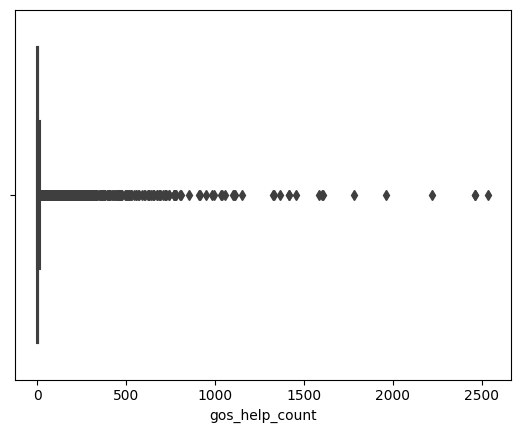

In [60]:
# посмотрим на распределение данного признака, в целях выявления выбросов
sns.boxplot(data=df[df.gos_help_count != 0], x='gos_help_count');

In [61]:
# максимальные значения данного признака
df['gos_help_count'].sort_values(ascending=False).head(10)

144085    2538
392322    2461
326975    2461
66265     2222
566340    1960
399372    1785
400006    1607
582973    1602
490983    1587
106685    1456
Name: gos_help_count, dtype: int64

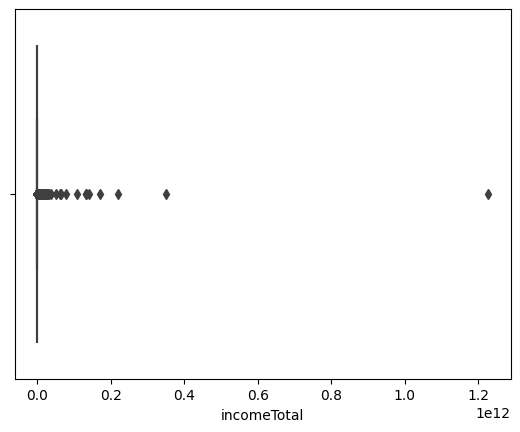

In [62]:
# посмотрим на распределение признака общего дохода, в целях выявления выбросов
sns.boxplot(data=df[df.incomeTotal != 0], x='incomeTotal');

In [63]:
# максимальные значения данного признака
df['incomeTotal'].sort_values(ascending=False).head(10)/1000000000

106223    1227.755896
243784     349.406707
228365     220.617223
249520     170.938595
711698     139.569241
342533     132.906507
137685     132.083246
249077     108.220280
252843      76.500000
138213      63.083504
Name: incomeTotal, dtype: float64

In [64]:
# в признаке общего дохода явно выделяется последнее значение, поэтому подкорректируем его
df['incomeTotal'].loc[106223] = df['incomeTotal'].loc[243784]+1
df['incomeTotal'].describe()

count    5.423060e+05
mean     5.439036e+06
std      8.739476e+08
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      3.494067e+11
Name: incomeTotal, dtype: float64

In [65]:
# проверим соотвествие признаков incomeTotal и gos_help_count
df[df.incomeTotal>0].shape, df[df.gos_help_count>0].shape

((33209, 40), (33300, 40))

Размеры данных признаков не совпадают. Можно предположить, что либо не указан доход, либо ошибочно указано количество.

In [66]:
# обнулим количество, если не указан доход
df.loc[df['incomeTotal'] == 0, 'gos_help_count'] = 0
df[df.incomeTotal>0].shape, df[df.gos_help_count>0].shape

((33209, 40), (33209, 40))

In [67]:
# создадим целевую переменную получения/неполучения государственного финансирования на основе признака incomeTotal
df['target'] = df['incomeTotal'].apply(lambda x: 1 if x > 0 else 0)
# посмотрим сколько организаций получали госфинансирование
df['target'].value_counts()

0    509097
1     33209
Name: target, dtype: int64

## Преобразование остальных признаков

In [68]:
# сведения об учетных записях организации в соцсетях 
df.socialMedia[1]

{'youtube': None,
 'vk': None,
 'facebook': None,
 'twitter': None,
 'instagram': None,
 'ok': None}

In [69]:
# преобразуем в бинарный признак
def get_media(etem):
    if (etem['youtube'] is not None 
    or etem['vk'] is not None 
    or etem['facebook'] is not None 
    or etem['twitter'] is not None 
    or etem['instagram'] is not None
    or etem['ok'] is not None):
        return 1
    else:
        return 0

df['socialMedia'] = df['socialMedia'].apply(get_media)
df['socialMedia'].value_counts()

0    542300
1         6
Name: socialMedia, dtype: int64

In [70]:
# отчеты организации, поданные в Минюст РФ 
df.reports

0                                                        []
1         [{'localUrl': 'http://cdnx.h5.crftr.net/f/4,18...
2                                                        []
3                                                        []
4                                                        []
                                ...                        
747026                                                   []
747027                                                   []
747028                                                   []
747029                                                   []
747030                                                   []
Name: reports, Length: 542306, dtype: object

In [71]:
# преобразуем в бинарный признак
df['reports'] = df['reports'].apply(lambda x: 0 if x == [] else 1)
df['reports'].value_counts()

0    413323
1    128983
Name: reports, dtype: int64

In [72]:
# ОГРН и ИНН являются уникальными признаками, посмотрим на дубликаты по ним
print("количество дубликатов по огрн:", df.duplicated(['ogrn']).sum())

# т.к. в данных ИНН имеются пропуски, посмотрим дубликаты по ИНН и наименованию организации
print("количество дубликатов по инн:", df.duplicated(['inn', 'shortName']).sum())

количество дубликатов по огрн: 0
количество дубликатов по инн: 739


In [73]:
# посмотрим на статус организаций-дубликатов
inn_dupl = df[df.duplicated(['inn', 'shortName'], keep=False)]
inn_dupl['egrulStatus'].value_counts()

0    758
1     26
Name: egrulStatus, dtype: int64

Большинство организаций-дубликатов по ИНН являются недействующими, возможно из-за перерегистрации или ошибочной регистрации.

In [74]:
# удалим организации-дубликаты, осортировав их по наличию целевого признака, статусу и возрасту.
df = df.sort_values(['target', 'egrulStatus', 'age_org']).drop_duplicates(['inn', 'shortName'], keep='first')
df.duplicated(['inn', 'shortName']).sum()

0

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 541567 entries, 200253 to 152528
Data columns (total 41 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   regionName          541567 non-null  object 
 1   fullName            541567 non-null  object 
 2   ogrn                541567 non-null  int64  
 3   egrulStatus         541567 non-null  int64  
 4   regionCode          541567 non-null  int64  
 5   incomeTotal         541567 non-null  float64
 6   inn                 541451 non-null  float64
 7   address             541567 non-null  object 
 8   kpp                 541382 non-null  float64
 9   hasRegionalSupport  541567 non-null  int64  
 10  addOkved            541567 non-null  int64  
 11  shortName           471793 non-null  object 
 12  socialMedia         541567 non-null  int64  
 13  reports             541567 non-null  int64  
 14  status_name         12768 non-null   object 
 15  status_code         12768 non

In [76]:
# выведем названия столбцов, где число пропусков больше 0 
cols_null_percent = df.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
display(cols_with_null)

status_name    97.642397
status_code    97.642397
oktmo_name     50.502154
okato_name     39.955536
okogu_name     38.369398
okfs_name      38.367552
okfs_code      38.367552
okogu_code     38.367552
oktmo_code     38.367552
okato_code     38.367552
shortName      12.883724
opf_code        4.848892
kpp             0.034160
inn             0.021419
opf_ver         0.004432
dtype: float64

In [77]:
# посмотрим на уникальные значения
df.nunique()

regionName                86
fullName              478957
ogrn                  541567
egrulStatus                2
regionCode                92
incomeTotal            27481
inn                   541411
address               477401
kpp                     3080
hasRegionalSupport         2
addOkved                 255
shortName             395542
socialMedia                2
reports                    2
status_name               18
status_code               18
age_org                  681
mainOkved_name          1921
mainOkved_code          2040
mainOkved_ver              2
addOkved_bool              2
opf_name                 237
opf_code                 139
opf_ver                    3
opf_group                 14
okfs_name                 27
okfs_code                 27
okogu_name                67
okogu_code                71
oktmo_name             21061
oktmo_code             27432
okato_name             21451
okato_code             27700
grants_count              13
grants_sum    

In [78]:
# удалим признаки, в которых есть пропуски, а также неинформативные и дублирующие признаки
columns = ['regionName', 'age_org', 'hasRegionalSupport', 'mainOkved_name', 'addOkved', 'addOkved_bool', 
           'opf_group', 'socialMedia', 'reports', 'gos_help_count', 'incomeTotal', 'target']
df_clean = df[columns]
df_clean.isnull().sum()

regionName            0
age_org               0
hasRegionalSupport    0
mainOkved_name        0
addOkved              0
addOkved_bool         0
opf_group             0
socialMedia           0
reports               0
gos_help_count        0
incomeTotal           0
target                0
dtype: int64

In [79]:
# сохраним предобработанный файл
df_clean.to_csv('data/df_clean.csv', index=False)